## В этом ноутбуке мы будем работать над текстами эпикризов, а именно анамнезов в этих эпикризах. Попробуем кластеризовать эти тексты.
Будем действовать следующим образом:

1) Возьмем веса трансформерной нейросети BERT, создадим эмбеддинги наших анамнезов

2) Снизим размерность BERT-эмбеддингов с помощью umap

3) Кластеризуем эмбеддинги алгоритмом HDBSCAN с подобранными экспериментально гиперпараметрами

4) Посмотрим на топ-слова из текстов каждого кластера, оценим качество кластеризации с помощью своеобразного user-study

### Отберем отдельно анамнезы в эпикризах. Анамнезы - самые обширные данные в эпикризах. Там тысячи символов по каждому пациенту в различное время. Считаем, что нам они понадобятся в большей степени

In [ ]:
import pandas as pd
data = pd.read_csv('/content/all_train_val_test_16_05.csv')
#data = pd.read_csv('/content/clustering_d2t_data.csv')

In [ ]:
data

,Unnamed: 0,T_PERSON_ID,ID,DOC_DATE_labres,ALL_TEXTS,effectiveness,DATE_START_THERAPY,DOC_DATE_epicrisis,Anamnesis,MKBCODE_head,MKBCODE_acomp,DOC_DATE_diag,timedelta,RADIODOSE,DIAG_RESULTS,ALLERGIC,OBJECTIVE,COMPLAINTS
0,0,6368,78460,2021-11-18,Пациент - мужчина. Пациенту 66 года. Пациент с...,1,2021-11-26,2021-11-29,"болен ревматоидным артритом с 1990г, однако дл...",M05.3,I25,2021-11-29,8,0.005,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 18...",отрицает,Общее состояние: удовлетворительное; Конституц...,"на боли в мелких суставах кистей, лучезапястны..."
1,1,10037,56420,2021-06-09,Пациент - женщина. Пациенту 67 года. Пациент с...,1,2021-06-18,2021-06-21,Периодические боли в различных суставах отмеча...,M05.3,E11.3I20I10H25.0M15N20K29.5I83.9,2021-06-22,9,0.050,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 09...","ацетилсалициловая кислота, диклофенак - отек К...",Общее состояние: удовлетворительное; Конституц...,"при поступлении жалобы на боль в плечевых, лок..."
2,2,10238,53078,2021-05-20,Пациент - женщина. Пациенту 57 года. Пациент с...,0,2021-05-01,2021-05-27,"считает себя больной с 1992г., в дебюте артрит...",M05.3,H11.8,2021-05-28,19,0.060,ЭКГ от 20.05.2021: Ритм синусовый с ЧСС- 74 уд...,отрицает,Общий статус Рост: 172; вес: 68; ИМТ: 22.99; Т...,на боли и припухлость в мелких суставах кистей...
3,3,10325,112422,2022-08-09,Пациент - женщина. Пациенту 65 года. Пациент с...,1,2022-08-15,2022-08-19,"Со слов, больна с 1993,д-з Ревматоидный артрит...",M05.3,0,2022-08-19,6,0.210,ОТДЕЛЕНИЕ ЛУЧЕВОЙ ДИАГНОСТИКИ Протокол № 11729...,ингибиторы ПАПФ - отек гортани пирацетам- поте...,: Общее состояние: средней тяжести; Конституци...,боли и припухание мелких суставов кистей и сто...
4,4,10951,73993,2021-10-15,Пациент - мужчина. Пациенту 65 года. Пациент с...,1,2021-10-21,2021-10-28,"болен с 2005 г., когда впервые развились артри...",M05.3,H02,2021-10-25,6,3.412,КОМПЬЮТЕРНАЯ ТОМОГРАФИЯ ОРГАНОВ ГРУДНОЙ КЛЕТКИ...,отрицает.,Общее состояние: удовлетворительное. Конституц...,"боли в левом плечевом, лучезапястных, локтевых..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,297,101267,117514,2022-09-15,Пациент - женщина. Пациенту 46 года. Пациент с...,1,2022-09-26,2022-09-27,"Считает себя больной с 1998г., когда отметила ...",M05.3,K21.0I84I69.0I11.9K50.1M31.8D86.9H19.3Q28H35.8...,2022-09-27,11,7.692,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 14...",Анальгин - зуд кистей и першение в горле. Флук...,Общее состояние: удовлетворительное; Конституц...,"боль и припухлость мелких суставов кистей, луч..."
298,298,103020,125014,2022-11-03,Пациент - мужчина. Пациенту 57 года. Пациент с...,1,2022-11-10,2022-11-15,"Считает себя больным с января 2022 г., когда п...",M05.3,K74.6K30I50.1I11.9H35.0H27.8H04.1N40I49.1,2022-11-14,7,0.000,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 02...",аллергии отрицает,Общее состояние: удовлетворительное; Конституц...,"боль и припухлость мелких суставов кистей, луч..."
299,299,103946,124080,2022-10-28,Пациент - женщина. Пациенту 61 года. Пациент с...,1,2022-11-04,2022-11-07,"Болеет с 2011 г., дебют с артритов лучезапястн...",M05.3,M42.1M54.2Q82.8L85.3L29.8H25.0L60.3M15.0,2022-11-07,7,0.248,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 27...",аллергии отрицает,Общее состояние: удовлетворительное; Конституц...,"Боли и припухание коленных, лучезапястных, гол..."
300,300,104333,123464,2022-10-25,Пациент - мужчина. Пациенту 32 года. Пациент с...,1,2022-11-01,2022-11-02,Псориаз волосистой части головы с детства. У д...,M06.0,D50.8D23G90L40.0,2022-11-01,7,0.348,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 24...",аллергии отрицает,Общее состояние: удовлетворительное; Конституц...,"Боль в локтевых, л/з, мелких суставах кистей, ..."


### Создание эмбеддингов

In [ ]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039168 sha256=7e235fe12bf5bc22c166adc0de762128579404c1d93fa2e999622d13c6e347ac
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan


In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=0da2881fbd332fe42952df9ac7b86b61a2fb583f7bf6f71f9db754232ae876bc
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
import json
import torch
import hdbscan
import matplotlib.pyplot as plt

In [ ]:
data = data.rename(columns={'Группа 3 (DT2)':'D2T'})

In [ ]:
data['D2T'] = data['D2T'].apply(lambda x: 1 if x == 'да' else 0)

<Axes: >

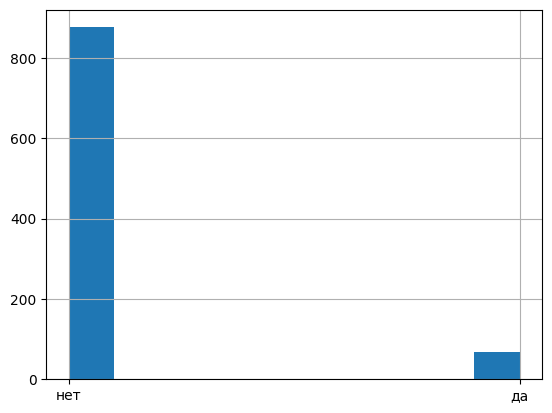

In [ ]:
data.D2T.hist()

<Axes: >

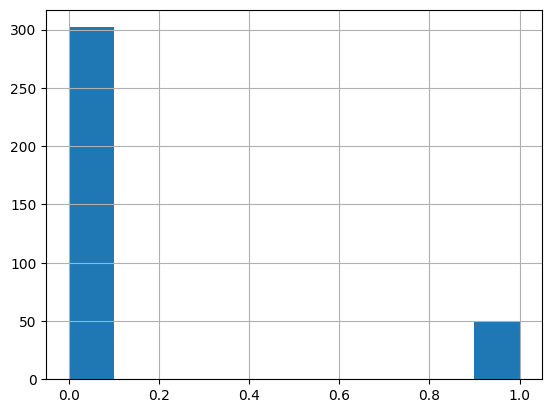

In [ ]:
data.D2T.hist()

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [ ]:
data.isna().sum()

Unnamed: 0            0
T_PERSON_ID           0
ID                    0
DOC_DATE_labres       0
ALL_TEXTS             0
effectiveness         0
DATE_START_THERAPY    0
DOC_DATE_epicrisis    0
Anamnesis             0
MKBCODE_head          0
MKBCODE_acomp         0
DOC_DATE_diag         0
timedelta             0
RADIODOSE             0
DIAG_RESULTS          0
ALLERGIC              0
OBJECTIVE             0
COMPLAINTS            0
dtype: int64

In [ ]:
values = {'DOC_DATE_preparate': 0,
          'RADIODOSE': 0,
          'DIAG_RESULTS': '',
          'ALLERGIC': '',
          'OBJECTIVE': '',
          'COMPLAINTS': '',
          'Anamnesis': ''
          }
data.fillna(value=values, inplace=True)
data

,Unnamed: 0,effectiveness,T_PERSON_ID,DOC_DATE_preparate,D2T,ID,DOC_DATE_epicrisis,Anamnesis,RADIODOSE,DIAG_RESULTS,ALLERGIC,OBJECTIVE,COMPLAINTS
0,0,0,16697.0,2023-03-22 00:00:00,нет,91798.0,2022-03-15,считает себя больным с 2014г. в дебюте артрит ...,2.387,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 03...",отрицает,Общее состояние: удовлетворительное; Конституц...,"на боли в правом лучезапястном, правом голенос..."
1,1,0,100671.0,2022-03-01 00:00:00,нет,118720.0,2022-09-30,С 2010-11гг - появились боли в суставах 1-ых п...,0.212,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 22...",отрицает,Общее состояние: удовлетворительное; Конституц...,на боли в мелких суставах кистей и стоп с их п...
2,2,0,68475.0,2021-12-24 00:00:00,нет,83358.0,2021-12-28,"считает себя больной с 2011г, когда впервые в ...",0,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 20...",отрицает,Общее состояние: средней тяжести; Конституция:...,на боли воспалительного ритма практически во в...
3,3,0,72562.0,ноя.17,нет,88992.0,2022-02-18,Дебют заболевания в августе 2015 года с артрит...,1.013,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 14...","хумира - крапивница, удушье, снижение АД.",Общее состояние: удовлетворительное. Конституц...,"на боли в лучезапястных суставах, в мелких сус..."
4,4,1,13776.0,2020-07-23 00:00:00,нет,11269.0,2020-07-27,"Давность заболевания с 2008г, дебют с артрита ...",1.078мЗв,ЭГДС от 16.07.2020г.: Заключение: Язва луковиц...,без особенностей,Общее состояние: удовлетворительное. Телосложе...,"на боли во всех суставах, наиболее выраженные ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,939,1,55200.0,2023-10-16 00:00:00,нет,82982.0,2021-12-21,"Заболела в 2009 г., дебют заболевания с боли в...",0,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 17...",отрицает,Общее состояние: удовлетворительное; Конституц...,"Боли в плечевых, лучезапястных, мелких сустава..."
940,940,1,11034.0,2023-10-20 00:00:00,нет,20948.0,2020-10-21,"считает себя больной с 2010г., в дебюте артрал...","0,046 мзв","16.10.20 ЭКГ: синусовый ритм с ЧСС 69/мин, ЭОС...",отрицает,Общее состояние: удовлетворительное; Конституц...,"боли, припухание и ограничение подвижности в м..."
941,941,1,20013.0,2023-10-20 00:00:00,нет,47089.0,2021-04-22,"считает себя больной с декабря 2017 года, когд...",0,"ЭКГ от 13.04.2021:ЗАКЛЮЧЕНИЕ: Ритм синусовый, ...",не отягощен,Общее состояние: средней тяжести; Конституция:...,"на боли в коленных, голеностопных суставах, ск..."
942,942,1,36519.0,2023-03-21 00:00:00,нет,39991.0,2021-03-10,"считает себя больным с 2016 года, когда впервы...",0,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 04...",спокойный,Общее состояние: удовлетворительное; Конституц...,припухлость и болезненность в области мелких с...


Заполняем пропуски пустой строкой. Это не повлияет ни на что по идее

In [ ]:
data.isna().sum()

Unnamed: 0            0
effectiveness         0
T_PERSON_ID           0
DOC_DATE_preparate    0
D2T                   0
ID                    0
DOC_DATE_epicrisis    0
Anamnesis             0
RADIODOSE             0
DIAG_RESULTS          0
ALLERGIC              0
OBJECTIVE             0
COMPLAINTS            0
dtype: int64

Создадим эмбеддинги с помощью BERT

In [ ]:
def create_embedding(table, model):
  embeddings_anam = model.encode(table['Anamnesis'], show_progress_bar=True)
  embeddings_dr = model.encode(table['DIAG_RESULTS'], show_progress_bar=True)
  embeddings_allergic = model.encode(table['ALLERGIC'], show_progress_bar=True)
  embeddings_objective = model.encode(table['OBJECTIVE'], show_progress_bar=True)
  embeddings_complaints = model.encode(table['COMPLAINTS'], show_progress_bar=True)
  embeddings_all = embeddings_anam + embeddings_dr + embeddings_allergic + embeddings_objective + embeddings_complaints
  return embeddings_all

In [ ]:
embeddings_all = create_embedding(data, model)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
len(embeddings_all[0])

512

### Снижение размерности

BERT создает 512-мерные вектора, нам такие огромные пихать в кластеризационные алгоритмы не есть хорошо, поэтому воспользуемся методом снижения размерности, а именно umap, и уменьшим размерности векторов до 10

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=945d73bcda875df80b44ee623eb72dfd30a1cf661ab66029ee743361431fe0b6
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=5b94e3749364a2e674c5bbb8859aa733d79ef30305d7bb4b715085ec84bdaae1
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=50,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings_all)

In [ ]:
len(umap_embeddings[0])

5

Будем использовать алгоритм HDBSCAN для кластеризации, так как он не требует заранее задавать количество кластеров. Основывается на внутренней функции плотность, и если кластер достигает определенного порога плотность - он выделяется. Таким образом мы можем получить большое количество кластеров, а затем отсеять имеющие особую ценность для нас

### Кластеризация

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
pd.Series(cluster.labels_).unique()

array([ 0,  2, -1,  1])

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
#для визуализации нарисуем 2-мерные вектора
umap_data = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_all)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

In [ ]:
result['D2T'] = data['D2T']

In [ ]:
result['effectiveness'] = data['effectiveness']

Теперь нарисуем на двумерной плоскости наши вектора и их кластеры. Кластеры возьмем из 5-мерных векторов, а положения двумерные

In [ ]:
result

,x,y,labels,D2T,effectiveness
0,10.623131,0.985960,4,0,0
1,10.463125,1.529369,4,0,0
2,9.923989,1.329890,4,0,0
3,16.500389,7.664660,1,0,0
4,4.148462,7.452512,0,0,1
...,...,...,...,...,...
939,9.983913,1.047753,4,0,1
940,9.869614,1.529777,4,0,1
941,10.235588,4.007736,3,0,1
942,10.311197,3.759041,3,0,1


In [ ]:
len(outliers)

3

Text(0.5, 1.0, 'First GEBD patients clustering 2D-visualization')

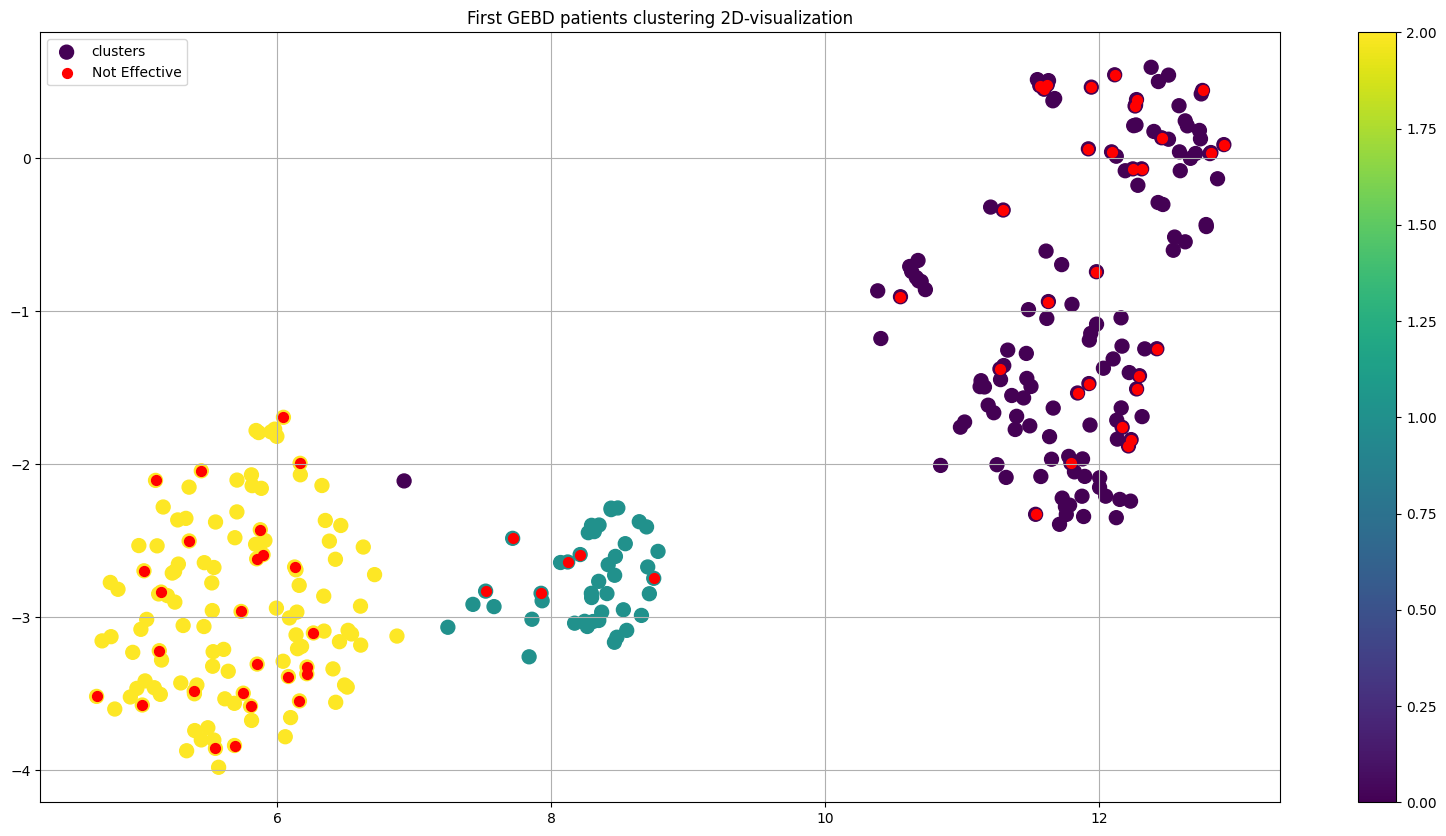

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
clustered_effectiveness = result.loc[result.effectiveness == 1, :]
clustered_not_effectiveness = result.loc[result.effectiveness != 1, :]
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
#plt.scatter(outliers.x, outliers.y, color='#d62728', s=25, label='Outliers')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=100, label='clusters')
plt.colorbar()

#plt.scatter(clustered_effectiveness.x, clustered_effectiveness.y, c='green', s=50, label='Effective')
plt.scatter(clustered_not_effectiveness.x, clustered_not_effectiveness.y, color='red', s=50, label='Not Effective')
plt.grid()
plt.legend()
plt.title('First GEBD patients clustering 2D-visualization')
#plt.savefig('clusters_anamnesis.png')

Text(0.5, 1.0, 'Whole text data clustering 2D-visualization')

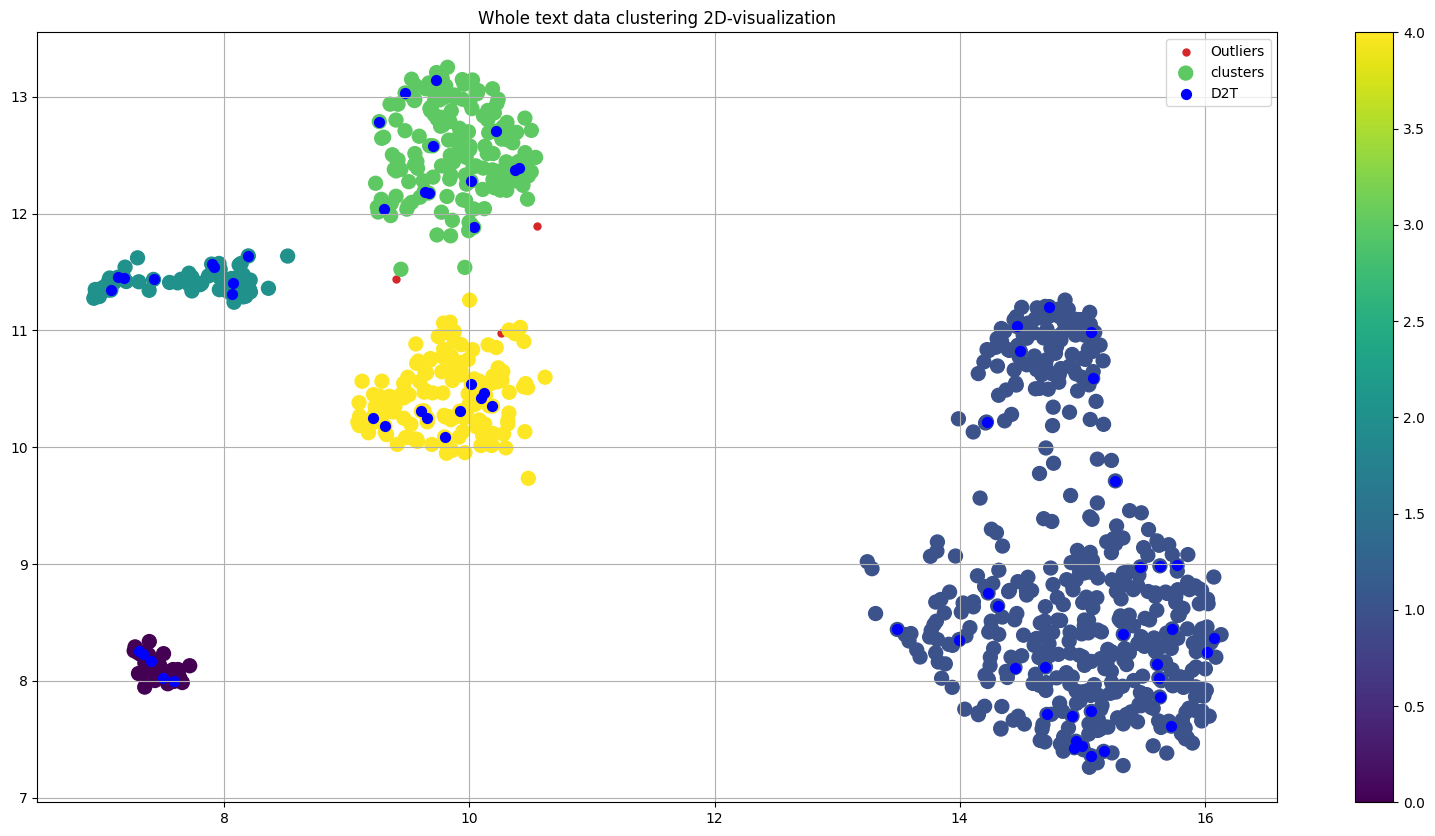

In [ ]:
# Visualize clusters
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
clustered_d2t = result.loc[result.D2T == 1, :]
clustered_effectiveness = result.loc[result.effectiveness == 1, :]
clustered_not_effectiveness = result.loc[result.effectiveness != 1, :]
#clustered = clustered.loc[clustered.labels != 1, :]
plt.scatter(outliers.x, outliers.y, color='#d62728', s=25, label='Outliers')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=100, label='clusters')
plt.colorbar()
plt.scatter(clustered_d2t.x, clustered_d2t.y, c='blue', s=50, label='D2T')
plt.grid()
plt.legend()
plt.title('Whole text data clustering 2D-visualization')
#plt.savefig('whole_clustets_and_d2t.png')

Text(0.5, 1.0, 'Whole text data clustering 2D-visualization')

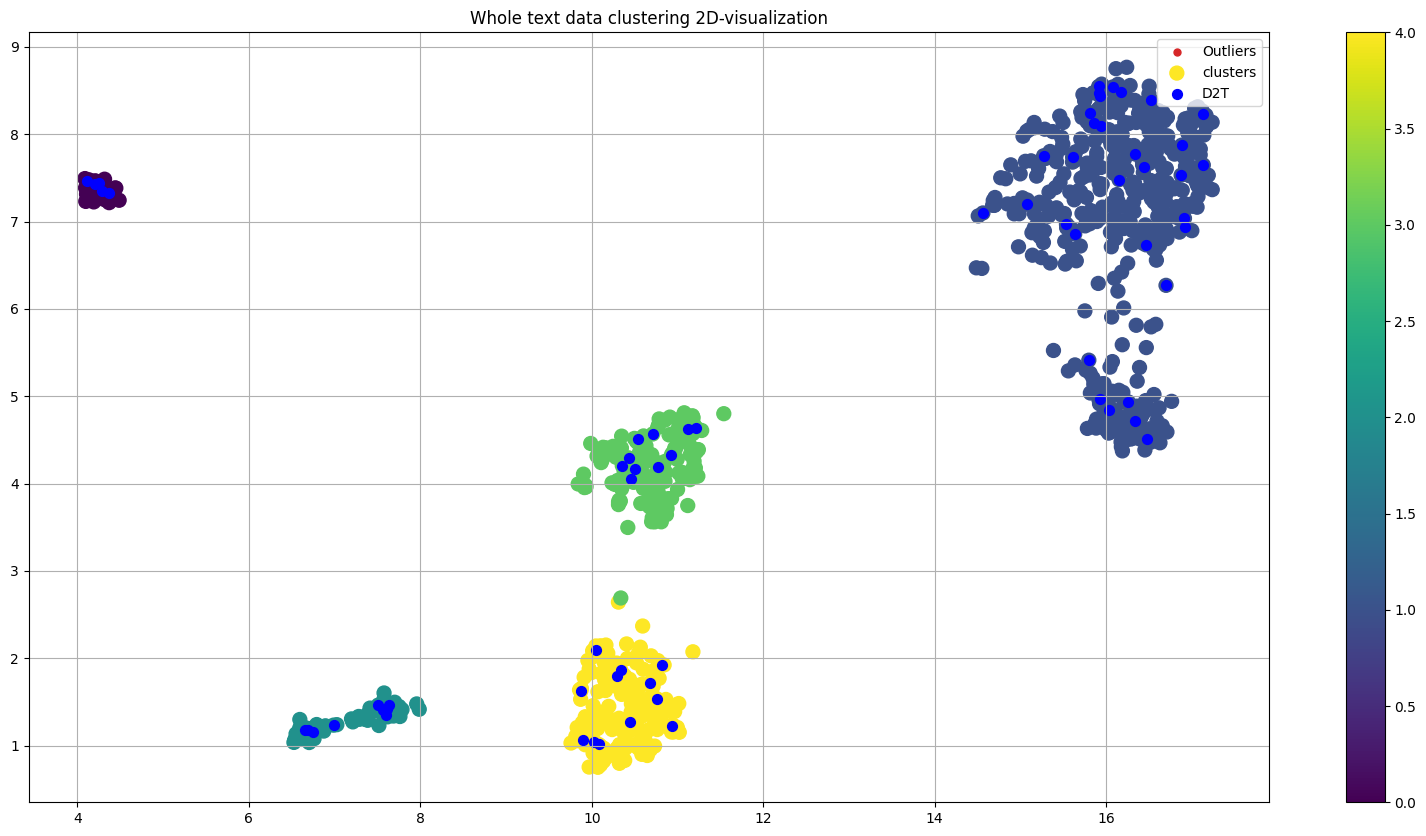

In [ ]:
# Visualize clusters
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
clustered_d2t = result.loc[result.D2T == 1, :]
clustered_effectiveness = result.loc[result.effectiveness == 1, :]
clustered_not_effectiveness = result.loc[result.effectiveness != 1, :]
#clustered = clustered.loc[clustered.labels != 1, :]
plt.scatter(outliers.x, outliers.y, color='#d62728', s=25, label='Outliers')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=100, label='clusters')
plt.colorbar()
plt.scatter(clustered_d2t.x, clustered_d2t.y, c='blue', s=50, label='D2T')
plt.grid()
plt.legend()
plt.title('Whole text data clustering 2D-visualization')
#plt.savefig('whole_clustets_and_d2t.png')

Text(0.5, 1.0, 'Whole text data clustering visualization')

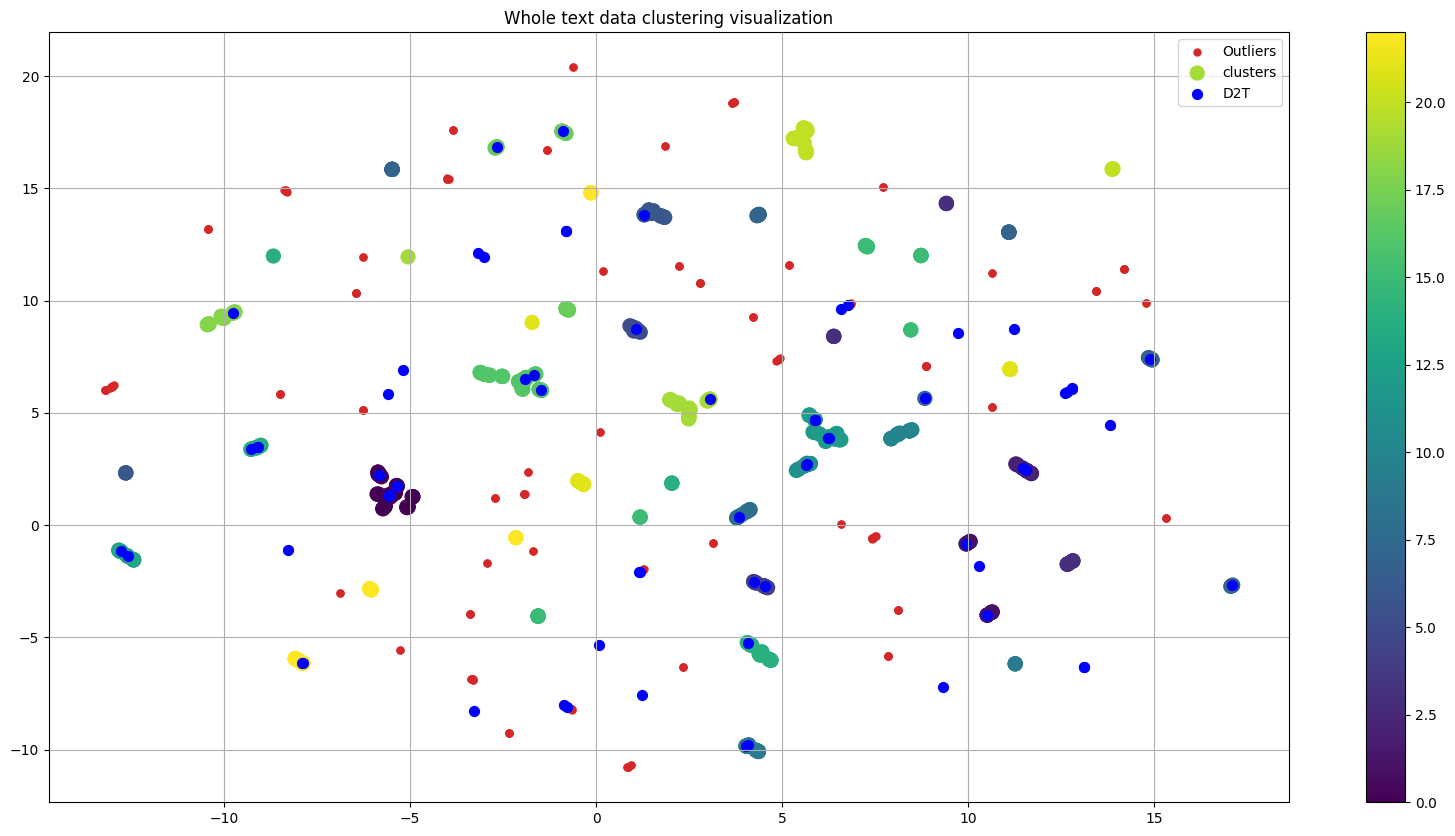

In [ ]:
# Visualize clusters
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
clustered_d2t = result.loc[result.D2T == 1, :]
clustered_effectiveness = result.loc[result.effectiveness == 1, :]
clustered_not_effectiveness = result.loc[result.effectiveness != 1, :]
#clustered = clustered.loc[clustered.labels != 1, :]
plt.scatter(outliers.x, outliers.y, color='#d62728', s=25, label='Outliers')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=100, label='clusters')
plt.colorbar()
plt.scatter(clustered_d2t.x, clustered_d2t.y, c='blue', s=50, label='D2T')
plt.grid()
plt.legend()
plt.title('Whole text data clustering visualization')
#plt.savefig('whole_clustets_and_d2t.png')

Text(0.5, 1.0, 'Whole text data clustering visualization')

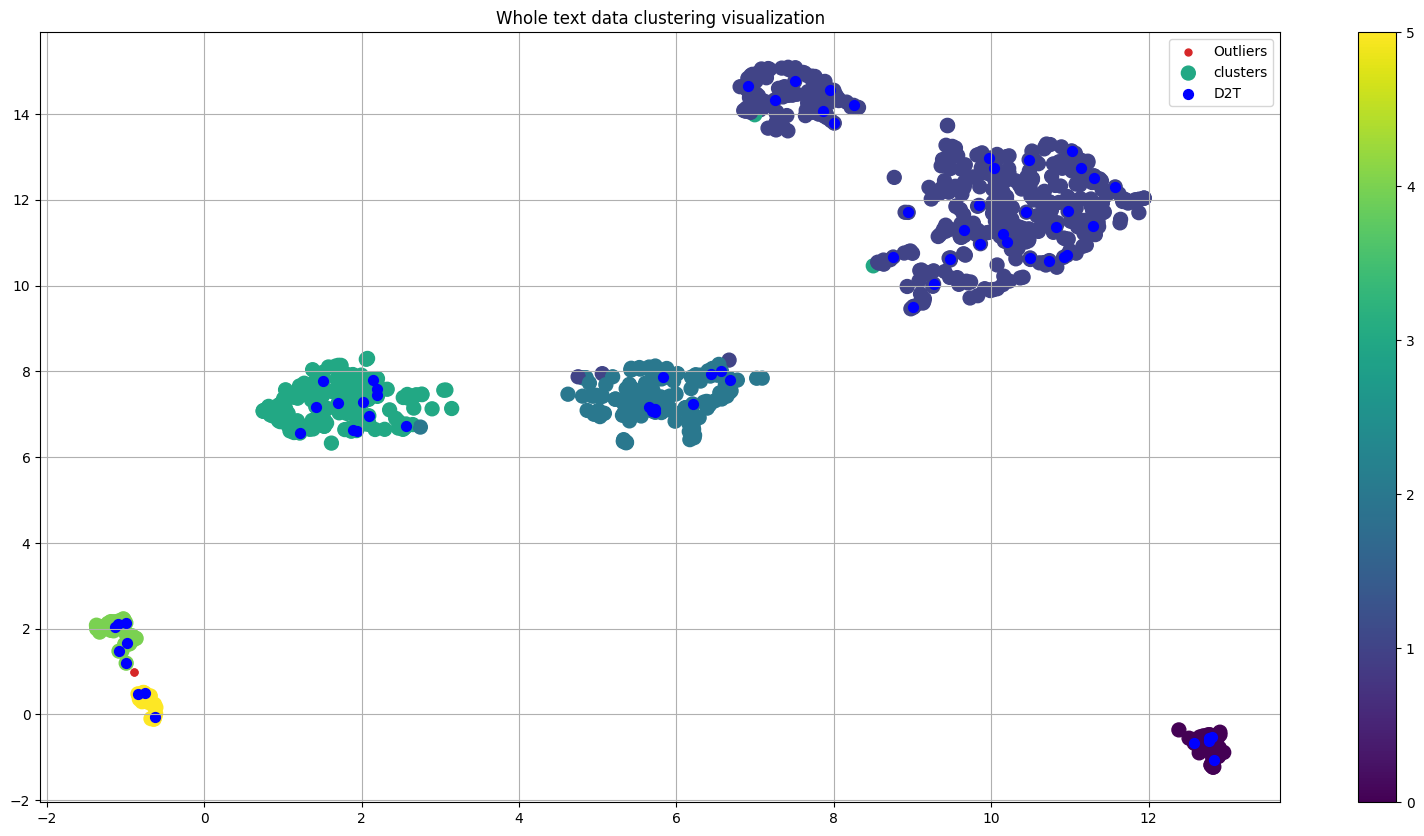

In [ ]:
# Visualize clusters
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
clustered_d2t = result.loc[result.D2T == 1, :]
clustered_effectiveness = result.loc[result.effectiveness == 1, :]
clustered_not_effectiveness = result.loc[result.effectiveness != 1, :]
#clustered = clustered.loc[clustered.labels != 1, :]
plt.scatter(outliers.x, outliers.y, color='#d62728', s=25, label='Outliers')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=100, label='clusters')
plt.colorbar()
plt.scatter(clustered_d2t.x, clustered_d2t.y, c='blue', s=50, label='D2T')
plt.grid()
plt.legend()
plt.title('Whole text data clustering 2D-visualization')
#plt.savefig('whole_clustets_and_d2t.png')

In [ ]:
data_with_clustering = pd.concat([data,result[['x',	'y', 'labels']]], axis=1)

0
1    106
0     30
Name: effectiveness, dtype: int64
2
1    93
0    26
Name: effectiveness, dtype: int64
-1
1    3
Name: effectiveness, dtype: int64
1
1    38
0     6
Name: effectiveness, dtype: int64


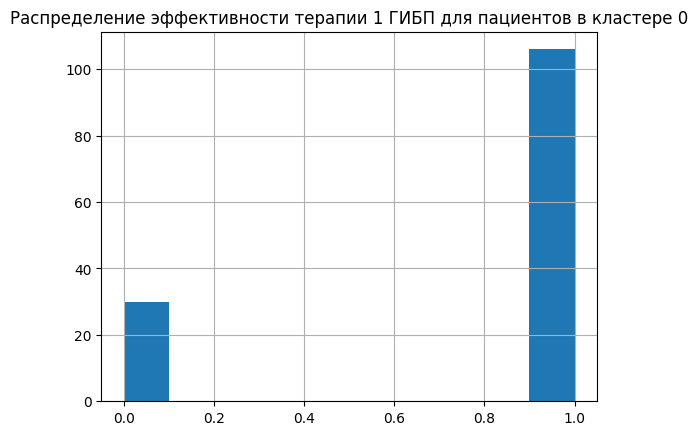

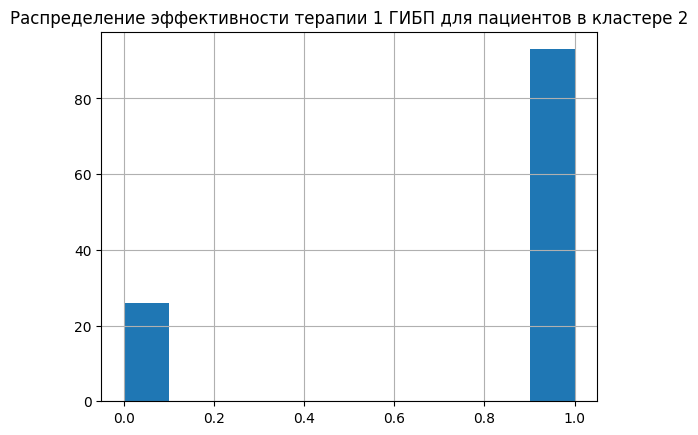

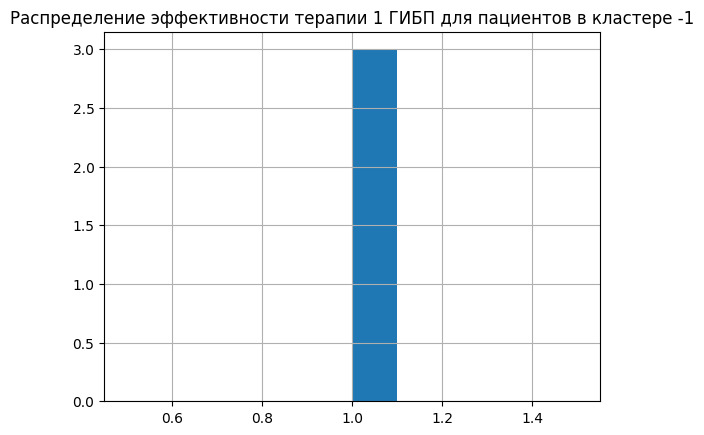

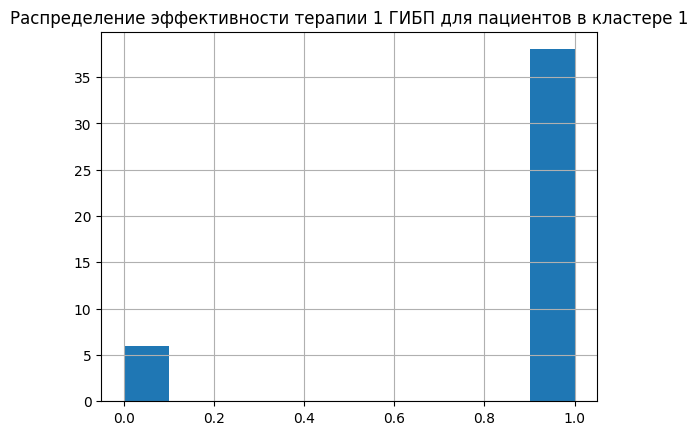

In [ ]:
import matplotlib.pyplot as plt
for cluster in data_with_clustering['labels'].unique():
  #plt.figure()
  #plt.title(f'Распределение D2T-пациентов в кластере {cluster}')
  #data_with_clustering[data_with_clustering['labels']==cluster]['D2T'].hist()
  print(cluster)
  print(data_with_clustering[data_with_clustering['labels']==cluster]['D2T'].value_counts())

D2T:

Особенный интерес представляет кластер 0. В нем относительно высокое процентное содержание пациентов D2T (9.8% против 6.6% в кластерах 4, 1, 3, больше только в кластере 2 - 11.1%). Кроме того этот кластер заметно выделяется среди других. Он меньше всех и эмбеддинги в этом кластере весьма сильно отличаются от других, что видно на двумерной проекции.

4: 168, 12

1: 446, 32

0: 46, 5

3: 143, 10

2: 72, 9

In [ ]:
data_best = data_with_clustering  #n_neighbors=50,
                                  #n_components=5,
                                  #min_cluster_size=15

In [ ]:
data_best.to_csv('data_best.csv')

In [ ]:
data_best = pd.read_csv('data_best.csv')

In [ ]:
import matplotlib.pyplot as plt
for cluster in data_best['labels'].unique():
  #plt.figure()
  #plt.title(f'Распределение D2T-пациентов в кластере {cluster}')
  #data_with_clustering[data_with_clustering['labels']==cluster]['D2T'].hist()
  print(data_best[data_best['labels']==cluster]['D2T'].value_counts())

0    168
1     12
Name: D2T, dtype: int64
0    447
1     32
Name: D2T, dtype: int64
0    46
1     5
Name: D2T, dtype: int64
0    143
1     10
Name: D2T, dtype: int64
0    72
1     9
Name: D2T, dtype: int64


эффективность 1 гибп:

0
1    106
0     30
Name: effectiveness, dtype: int64
2
1    93
0    26
Name: effectiveness, dtype: int64
-1
1    3
Name: effectiveness, dtype: int64
1
1    38
0     6
Name: effectiveness, dtype: int64


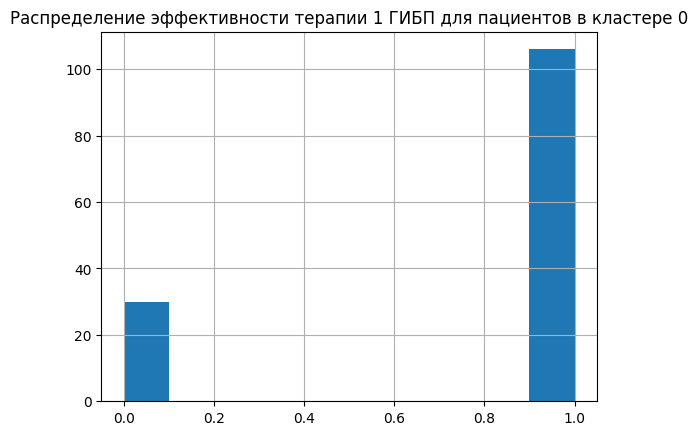

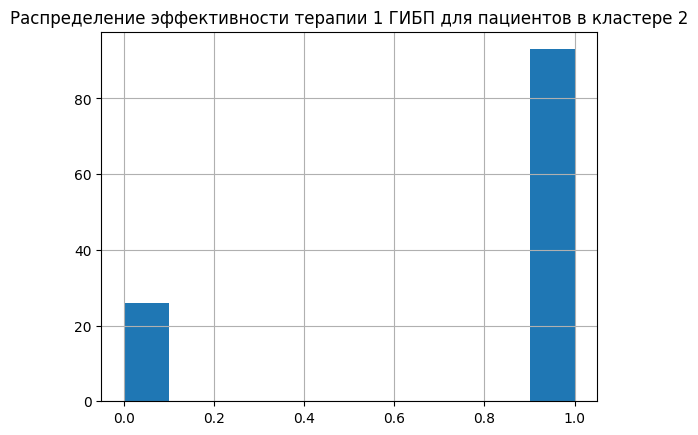

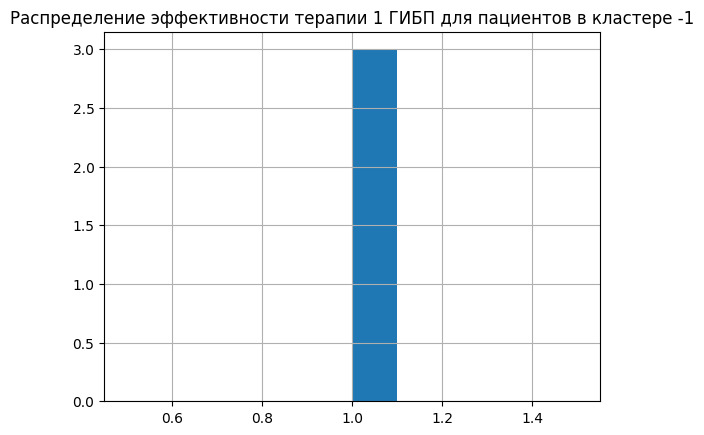

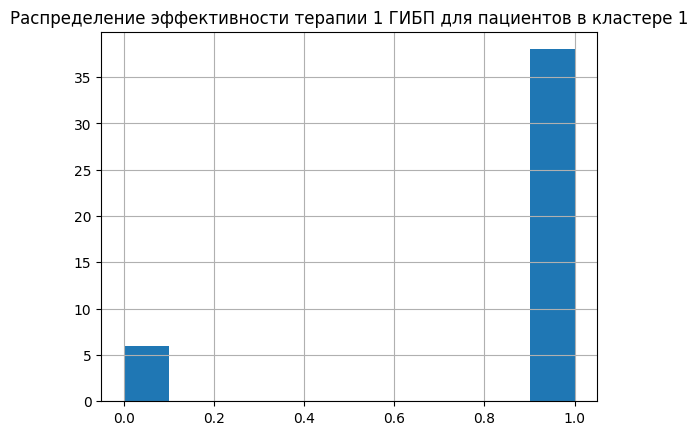

In [ ]:
import matplotlib.pyplot as plt
for cluster in data_with_clustering['labels'].unique():
  plt.figure()
  plt.title(f'Распределение эффективности терапии 1 ГИБП для пациентов в кластере {cluster}')
  data_with_clustering[data_with_clustering['labels']==cluster]['effectiveness'].hist()
  print(cluster)
  print(data_with_clustering[data_with_clustering['labels']==cluster]['effectiveness'].value_counts())

эффективность 1 гибп:

Особенный интерес представляет кластер 0. В нем относительно высокое процентное содержание пациентов D2T (9.8% против 6.6% в кластерах 4, 1, 3, больше только в кластере 2 - 11.1%). Кроме того этот кластер заметно выделяется среди других. Он меньше всех и эмбеддинги в этом кластере весьма сильно отличаются от других, что видно на двумерной проекции.

4: 168, 12

1: 446, 32

0: 46, 5

3: 143, 10

2: 72, 9

In [ ]:
data_best_1_gibp = data_with_clustering  #n_neighbors=50,
                                  #n_components=5,
                                  #min_cluster_size=10

data_best_1_gibp.to_csv('data_best_1_gibp.csv')

### Topic Modeling (выделяем топ-слова)

А теперь попробуем детальнее исследовать получившиеся кластеры и оценить их репрезентативность. Для этого мы проведем классическую предобработку текстов,
1) выкинув оттуда стоп-слова,
2) обучив CountVectorizer на n-граммах размером от 1 до 3 (считаем что максимум в 3 слова тут будет достаточно),
3) и затем посчитаем tf-idf. Таким образом мы сможем вывести топ-N (N=100 для первого прогона, так как может все же включать стоп-слова или какие-то буквицы) слов в каждом топике.
4) Затем, постобработаем и эти результаты и выведем топ-5 слов (уже точно содержащих содержательные вещи)

In [ ]:
import pandas as pd
data = pd.read_csv('whole_data_clustering_results.csv')

In [ ]:
data_from_second = pd.read_csv('from_first_and_second_gibp.csv')

In [ ]:
data_from_first = pd.read_csv('from_first_gibp.csv')

In [ ]:
data_from_second['PERSON_ID']

0     11367.0
1     12566.0
2      7612.0
3     45978.0
4     66812.0
5     36370.0
6     12548.0
7     36205.0
8     11616.0
9     57498.0
10    77178.0
11    13868.0
12    21104.0
13    56935.0
14    50402.0
15    12400.0
16        NaN
17    21413.0
18     9801.0
19     7805.0
Name: PERSON_ID, dtype: float64

In [ ]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'T_PERSON_ID', 'ID', 'DOC_DATE_labres',
       'ALL_TEXTS', 'effectiveness', 'DATE_START_THERAPY',
       'DOC_DATE_epicrisis', 'Anamnesis', 'MKBCODE_head', 'MKBCODE_acomp',
       'DOC_DATE_diag', 'timedelta', 'RADIODOSE', 'DIAG_RESULTS', 'ALLERGIC',
       'OBJECTIVE', 'COMPLAINTS', 'D2T', 'labels'],
      dtype='object')

In [ ]:
data_best_1_gibp[data_best_1_gibp['T_PERSON_ID'].isin(data_from_second['PERSON_ID'])]

,Unnamed: 0,T_PERSON_ID,ID,DOC_DATE_labres,ALL_TEXTS,effectiveness,DATE_START_THERAPY,DOC_DATE_epicrisis,Anamnesis,MKBCODE_head,...,DOC_DATE_diag,timedelta,RADIODOSE,DIAG_RESULTS,ALLERGIC,OBJECTIVE,COMPLAINTS,x,y,labels
196,196,50402,63522,2021-08-10,Пациент - женщина. Пациенту 56 года. Пациент с...,0,2021-08-01,2021-08-20,Псориаз кожи и ногтей с 16 лет. Считает себя б...,M05.8,...,2021-08-12,9,1.078,МАГНИТНО-РЕЗОНАНСНАЯ ТОМОГРАФИЯ КРЕСТЦОВО-ПОДВ...,преднизолон - тахикардия.,Общее состояние: удовлетворительное; Конституц...,боль в мелких суставах кистей и стоп лучезапяс...,5.448123,-2.042768,2


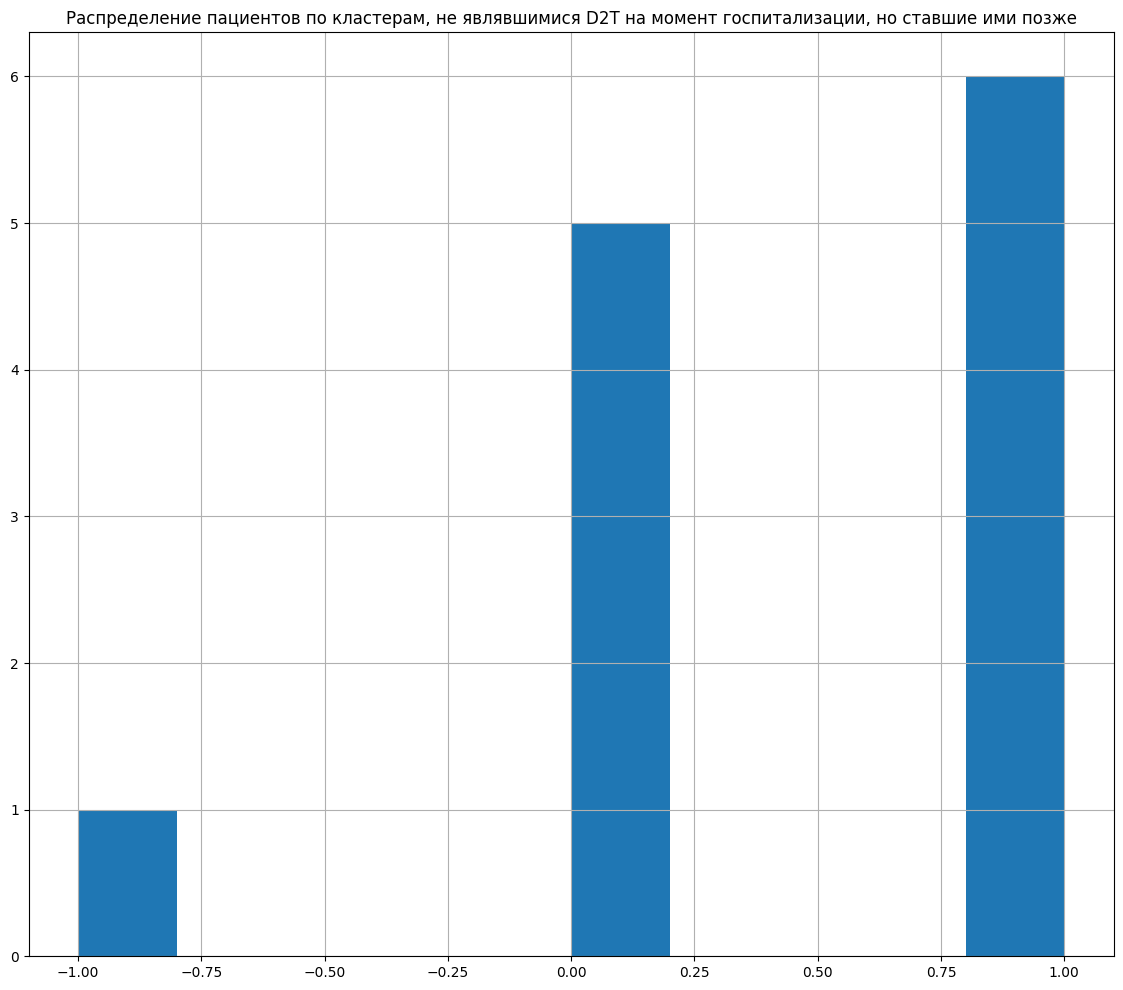

In [ ]:
plt.title('Распределение пациентов по кластерам, не являвшимися D2T на момент госпитализации, но ставшие ими позже')
data[data['T_PERSON_ID'].isin(data_from_second['PERSON_ID'])].labels.hist(figsize=(14,12))
plt.savefig('dist_d2t_not_d2t.png')

In [ ]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 52.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=4519300ebf60aa59f61ac8f7f9d5cc427c7c9db6f863a6eac36ca04d8b657be7
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
data.drop_duplicates(subset='T_PERSON_ID')

,Unnamed: 0.1,Unnamed: 0,T_PERSON_ID,ID,DOC_DATE_labres,ALL_TEXTS,effectiveness,DATE_START_THERAPY,DOC_DATE_epicrisis,Anamnesis,...,MKBCODE_acomp,DOC_DATE_diag,timedelta,RADIODOSE,DIAG_RESULTS,ALLERGIC,OBJECTIVE,COMPLAINTS,D2T,labels
0,0,0,6368.0,78460.0,2021-11-18,Пациент - мужчина. Пациенту 66 года. Пациент с...,1.0,2021-11-26,2021-11-29,"болен ревматоидным артритом с 1990г, однако дл...",...,I25,2021-11-29,8.0,0.005,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 18...",отрицает,Общее состояние: удовлетворительное; Конституц...,"на боли в мелких суставах кистей, лучезапястны...",0,3
1,1,1,10037.0,56420.0,2021-06-09,Пациент - женщина. Пациенту 67 года. Пациент с...,1.0,2021-06-18,2021-06-21,Периодические боли в различных суставах отмеча...,...,E11.3I20I10H25.0M15N20K29.5I83.9,2021-06-22,9.0,0.05,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 09...","ацетилсалициловая кислота, диклофенак - отек К...",Общее состояние: удовлетворительное; Конституц...,"при поступлении жалобы на боль в плечевых, лок...",0,0
2,2,2,10238.0,53078.0,2021-05-20,Пациент - женщина. Пациенту 57 года. Пациент с...,0.0,2021-05-01,2021-05-27,"считает себя больной с 1992г., в дебюте артрит...",...,H11.8,2021-05-28,19.0,0.06,ЭКГ от 20.05.2021: Ритм синусовый с ЧСС- 74 уд...,отрицает,Общий статус Рост: 172; вес: 68; ИМТ: 22.99; Т...,на боли и припухлость в мелких суставах кистей...,0,3
3,3,3,10325.0,112422.0,2022-08-09,Пациент - женщина. Пациенту 65 года. Пациент с...,1.0,2022-08-15,2022-08-19,"Со слов, больна с 1993,д-з Ревматоидный артрит...",...,0,2022-08-19,6.0,0.21,ОТДЕЛЕНИЕ ЛУЧЕВОЙ ДИАГНОСТИКИ Протокол № 11729...,ингибиторы ПАПФ - отек гортани пирацетам- поте...,: Общее состояние: средней тяжести; Конституци...,боли и припухание мелких суставов кистей и сто...,0,0
4,4,4,10951.0,73993.0,2021-10-15,Пациент - мужчина. Пациенту 65 года. Пациент с...,1.0,2021-10-21,2021-10-28,"болен с 2005 г., когда впервые развились артри...",...,H02,2021-10-25,6.0,3.412,КОМПЬЮТЕРНАЯ ТОМОГРАФИЯ ОРГАНОВ ГРУДНОЙ КЛЕТКИ...,отрицает.,Общее состояние: удовлетворительное. Конституц...,"боли в левом плечевом, лучезапястных, локтевых...",0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,346,709,91622.0,113155.0,2022-08-11,Пациент - женщина. Пациенту 64 года. Пациент с...,NaN,NaN,2022-08-22,Анамнез собран со слов больной и предоставленн...,...,M81.8M41.8I67.8H90.4M15.0,2022-08-19,NaN,0.221,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 11...","Детралекс - крапивница, отек Квинке.",Общее состояние: удовлетворительное; Конституц...,боли воспалительного ритма в мелких суставах к...,1,0
347,347,718,95815.0,115638.0,2022-09-01,Пациент - женщина. Пациенту 64 года. Пациент с...,NaN,NaN,2022-09-13,"Больна с 2013 года, когда появились боли в луч...",...,K29.5M80.8,2022-09-13,NaN,0.096,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 30...",аллергии отрицает. НР: сульфасалазин+барицитин...,0,"на боли в плечевых, коленных, голеностопных, л...",1,2
348,348,727,101314.0,121764.0,2022-10-27,Пациент - женщина. Пациенту 54 года. Пациент с...,NaN,NaN,2022-10-25,Дебют заболевания в 09.2012г. с полиартритов м...,...,F48J44.9L60.3D23G25.0,2022-10-27,NaN,2.42,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 12...","Мабтера - отёк Квинке, Лефлуномид, метотрексат...",Общее состояние: удовлетворительное; Конституц...,"на боли в мелких суставах кистей, стоп, лучеза...",1,0
349,349,735,104692.0,124558.0,2022-11-07,Пациент - женщина. Пациенту 51 года. Пациент с...,NaN,NaN,2022-11-14,"Больна с мая 2006 г, когда впервые появились б...",...,K29.3D25.9H52.0,2022-11-09,NaN,0.14,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 31...","никотиновая кислота - головокружение, тошнота,...",Общее состояние: удовлетворительное; Конституц...,"боль и припухлость лучезапястных, мелких суста...",1,0


In [ ]:
data[data['T_PERSON_ID']==]

,Unnamed: 0.1,Unnamed: 0,T_PERSON_ID,ID,DOC_DATE_labres,ALL_TEXTS,effectiveness,DATE_START_THERAPY,DOC_DATE_epicrisis,Anamnesis,...,MKBCODE_acomp,DOC_DATE_diag,timedelta,RADIODOSE,DIAG_RESULTS,ALLERGIC,OBJECTIVE,COMPLAINTS,D2T,labels


In [ ]:
data = data_best

In [ ]:
data

,Unnamed: 0.1,Unnamed: 0,effectiveness,T_PERSON_ID,DOC_DATE_preparate,D2T,ID,DOC_DATE_epicrisis,Anamnesis,RADIODOSE,DIAG_RESULTS,ALLERGIC,OBJECTIVE,COMPLAINTS,x,y,labels
0,0,0,0,16697.0,2023-03-22 00:00:00,0,91798.0,2022-03-15,считает себя больным с 2014г. в дебюте артрит ...,2.387,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 03...",отрицает,Общее состояние: удовлетворительное; Конституц...,"на боли в правом лучезапястном, правом голенос...",10.623131,0.985960,4
1,1,1,0,100671.0,2022-03-01 00:00:00,0,118720.0,2022-09-30,С 2010-11гг - появились боли в суставах 1-ых п...,0.212,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 22...",отрицает,Общее состояние: удовлетворительное; Конституц...,на боли в мелких суставах кистей и стоп с их п...,10.463125,1.529369,4
2,2,2,0,68475.0,2021-12-24 00:00:00,0,83358.0,2021-12-28,"считает себя больной с 2011г, когда впервые в ...",0,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 20...",отрицает,Общее состояние: средней тяжести; Конституция:...,на боли воспалительного ритма практически во в...,9.923989,1.329891,4
3,3,3,0,72562.0,ноя.17,0,88992.0,2022-02-18,Дебют заболевания в августе 2015 года с артрит...,1.013,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 14...","хумира - крапивница, удушье, снижение АД.",Общее состояние: удовлетворительное. Конституц...,"на боли в лучезапястных суставах, в мелких сус...",16.500390,7.664659,1
4,4,4,1,13776.0,2020-07-23 00:00:00,0,11269.0,2020-07-27,"Давность заболевания с 2008г, дебют с артрита ...",1.078мЗв,ЭГДС от 16.07.2020г.: Заключение: Язва луковиц...,без особенностей,Общее состояние: удовлетворительное. Телосложе...,"на боли во всех суставах, наиболее выраженные ...",4.148462,7.452512,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,939,939,1,55200.0,2023-10-16 00:00:00,0,82982.0,2021-12-21,"Заболела в 2009 г., дебют заболевания с боли в...",0,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 17...",отрицает,Общее состояние: удовлетворительное; Конституц...,"Боли в плечевых, лучезапястных, мелких сустава...",9.983913,1.047753,4
940,940,940,1,11034.0,2023-10-20 00:00:00,0,20948.0,2020-10-21,"считает себя больной с 2010г., в дебюте артрал...","0,046 мзв","16.10.20 ЭКГ: синусовый ритм с ЧСС 69/мин, ЭОС...",отрицает,Общее состояние: удовлетворительное; Конституц...,"боли, припухание и ограничение подвижности в м...",9.869614,1.529777,4
941,941,941,1,20013.0,2023-10-20 00:00:00,0,47089.0,2021-04-22,"считает себя больной с декабря 2017 года, когд...",0,"ЭКГ от 13.04.2021:ЗАКЛЮЧЕНИЕ: Ритм синусовый, ...",не отягощен,Общее состояние: средней тяжести; Конституция:...,"на боли в коленных, голеностопных суставах, ск...",10.235588,4.007736,3
942,942,942,1,36519.0,2023-03-21 00:00:00,0,39991.0,2021-03-10,"считает себя больным с 2016 года, когда впервы...",0,"РЕГИСТРАЦИЯ И ОПИСАНИЕ ЭЛЕКТРОКАРДИОГРАММЫ, 04...",спокойный,Общее состояние: удовлетворительное; Конституц...,припухлость и болезненность в области мелких с...,10.311197,3.759041,3


In [ ]:
data = data.fillna('')

In [ ]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=02cec140a6c413fd72f2797698fe57fdc4b2c4df19bd4dfe1fb67318deb7ae3a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
docs_df = pd.DataFrame(list(data['Anamnesis']), columns=["Doc"])
docs_df['Topic'] = data['labels']
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})  #это будет нужно в дальнейшем

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import pymorphy2
from tqdm import tqdm
tqdm.pandas()
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 4)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords.words('russian')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data['Anamnesis']))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=100):
    """
    вытаскивает топ-слов топика

    """
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)

    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    """
    вытаскивает размер топиков (просто посмотреть статистику)

    """
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=100)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
1,1,479
4,4,180
3,3,153
2,2,81
0,0,51


In [ ]:
top_n_words  #не очень то удобный вид, посмотрим получше ниже

In [ ]:
top = pd.DataFrame(top_n_words).astype('str') #переведем в df

In [ ]:
#теперь выведем более красиво топики, чтобы можно было на топ-слова посмотреть.
import re
out_cols = dict.fromkeys(top.columns[0:], [])
for col in top.columns[0:]:
    top_words = list(top[col])[:50]
    out_top_words = []
    for s in top_words:
        s = re.sub('[^а-я]', ' ', s)
        if len(re.sub('[^а-я]', '', s)) >= 4:
            out_top_words.append(s)
        out_top_words = out_top_words[:30]
    out_cols[col] = out_top_words
top_words = pd.DataFrame(out_cols)
top_words

,0,1,2,3,4
0,давность заболевания,препарат,хорошим,госпитализации,мг нед
1,давность,приема,хорошим эффектом,госпитализирован,ревматологом
2,фаланговых суставов,отмечала,печени,легких,правого коленного сустава ...
3,институт,отмена,усиление,терапия метотрексатом,высокая
4,фаланговых,препарат отменен,ритуксимаба,мг неделю,мм срб
5,качестве базисной,таб,состояния,жидкости,мг нед
6,мг сутки,плаквенил,мес,переносимостью,правого коленного
7,рентген,снижение,больной,активности,оам
8,качестве базисной терапии ...,алт,преднизолона,получал,эрозивный
9,базисной,аст,усиление болей,картина,мг нед


In [ ]:
top_words

,0,1,2,3,4
0,давность заболевания,препарат,хорошим,госпитализации,мг нед
1,давность,приема,хорошим эффектом,госпитализирован,ревматологом
2,фаланговых суставов,отмечала,печени,легких,правого коленного сустава ...
3,институт,отмена,усиление,терапия метотрексатом,высокая
4,фаланговых,препарат отменен,ритуксимаба,мг неделю,мм срб
5,качестве базисной,плаквенил,состояния,жидкости,мг нед
6,мг сутки,снижение,больной,переносимостью,правого коленного
7,рентген,анализах крови,преднизолона,активности,эрозивный
8,качестве базисной терапии ...,шегрена,усиление болей,получал,мг нед
9,базисной,выявлено,отметила,картина,эффект


In [ ]:
top_words.to_csv('Anamnesis_top_words_clusters.csv')

In [ ]:
DIAG_RESULTS	ALLERGIC	OBJECTIVE	COMPLAINTS

In [ ]:
docs_df = pd.DataFrame(list(data['COMPLAINTS']), columns=["Doc"])
docs_df['Topic'] = data['labels']
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})  #это будет нужно в дальнейшем

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data['COMPLAINTS']))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=100)
topic_sizes = extract_topic_sizes(docs_df)

top = pd.DataFrame(top_n_words).astype('str')

import re
out_cols = dict.fromkeys(top.columns[0:], [])
for col in top.columns[0:]:
    top_words = list(top[col])[:50]
    out_top_words = []
    for s in top_words:
        s = re.sub('[^а-я]', ' ', s)
        if len(re.sub('[^а-я]', '', s)) >= 4:
            out_top_words.append(s)
        out_top_words = out_top_words[:30]
    out_cols[col] = out_top_words
top_words = pd.DataFrame(out_cols)
top_words.to_csv('COMPLAINTS_top_words_clusters.csv')
top_words

,0,1,2,3,4
0,продолжительностью,припухание,припухлость,мелких суставах кистей,утренняя
1,скованность продолжительностью ...,сухость,кистей лучезапястных,суставах мелких суставах ...,утренняя скованность
2,утренняя скованность продолжительностью ...,кистей стоп,боль припухлость,коленных суставах,часов
3,суставе,плечевых,течение,суставах мелких,мелких суставов
4,правом,мелких суставов,голеностопных суставах,суставах кистей,припухание
5,мелких суставов,суставов кистей,кистей лучезапястных суставов ...,суставах кистей стоп,левом
6,утренняя скованность,боли припухание,утренняя скованность суставах ...,локтевых,суставов кистей
7,утренняя,голеностопных,лучезапястных,мелких суставах кистей стоп ...,мелких суставов кистей
8,боли припухлость,мелких суставов кистей,поясничном отделе позвоночника ...,часа,кистей стоп
9,боли припухлость мелких,часов,голеностопных,кистей стоп,голеностопных


In [ ]:
top_words.to_csv('Diag_Results_top_words_clusters.csv')

эффективность:

In [ ]:
data = data_best_1_gibp

In [ ]:
docs_df = pd.DataFrame(list(data['OBJECTIVE']), columns=["Doc"])
docs_df['Topic'] = data['labels']
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})  #это будет нужно в дальнейшем

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data['OBJECTIVE']))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=100)
topic_sizes = extract_topic_sizes(docs_df)

top = pd.DataFrame(top_n_words).astype('str')

import re
out_cols = dict.fromkeys(top.columns[1:], [])
for col in top.columns[1:]:
    top_words = list(top[col])[:50]
    out_top_words = []
    for s in top_words:
        s = re.sub('[^а-я]', ' ', s)
        if len(re.sub('[^а-я]', '', s)) >= 4:
            out_top_words.append(s)
        out_top_words = out_top_words[:30]
    out_cols[col] = out_top_words
top_words = pd.DataFrame(out_cols)
top_words.to_csv('OBJECTIVE_1_GIBP_top_words_clusters.csv')
top_words

,0,1,2
0,слева,степень боли,свободное безболезненное ...
1,справа,степень,мочеиспускание свободное безболезненное ...
2,линии,нормальной окраски влажности ...,цвет
3,боли,влажности щитовидная железа щитовидная ...,лучезапястный левый
4,ребро,слизистые нормальной окраски влажности ...,мочеиспускание свободное ...
5,дополнительно,слизистые слизистые нормальной окраски ...,пальпации мягкий
6,обеих сторон,слизистые слизистые,удовлетворительное конституция гиперстеничес...
7,минуту дыхательная система ...,склеры видимые слизистые слизистые ...,левый плечевой
8,минуту дыхательная система частота ...,видимые слизистые слизистые нормальной ...,дистальный межфаланговый кисти ...
9,минуту дыхательная,видимые слизистые слизистые ...,плечевой правый


Замечаем, что кластеры получились не такие уж плохие. Видны тенденции, где-то было в анамнезе больше глазных болезней, как в кластере 42, где-то проблемы в полости рта, как в кластере 41. Когда будем проводить дальнейшие исследования, можем выделить в отдельный признак принадлежность текста к кластеру.